In [45]:
## Import Libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import re
import nltk
from wordcloud import WordCloud, STOPWORDS 
from nltk import sent_tokenize

from BinaryClassificationMetrics import weighted_avg_precision_score,precision_score
from xgboost.sklearn import XGBClassifier

In [2]:
df = pd.read_csv('spam.csv', encoding='latin-1')

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.dropna(inplace=True,axis=1)

In [5]:
len(df)

5572

In [6]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Text Prepocessing and EDA

In [7]:
df.rename(columns={'v1':'Label','v2':'Text'},inplace=True)

In [8]:
df['Label'].value_counts()

ham     4825
spam     747
Name: Label, dtype: int64

In [9]:
## Removing non-alphanumeric text

def clean_txt(text):
    text = re.sub('[^a-zA-Z0-9]',' ',text)
    return text

In [10]:
df['Text'] = df['Text'].apply(clean_txt)

In [11]:
df.head()

,Label,Text
0,ham,Go until jurong point crazy Available only ...
1,ham,Ok lar Joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor U c already then say
4,ham,Nah I don t think he goes to usf he lives aro...


In [12]:
## Forming a word cloud

stopwords = set(STOPWORDS)

texts_spam = ''
texts_ham = ''
corpus = []

## Seperating the words on the basis of spam and ham
for index in df.index:
    if (df['Label'][index]=='spam'):
        texts_spam = texts_spam + ". " + df['Text'][index]
    else:
        texts_ham = texts_ham + ". " + df['Text'][index]
    words = sent_tokenize(df['Text'][index])
    for word in words:
        corpus.append(word)

In [13]:
spamcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(texts_spam)

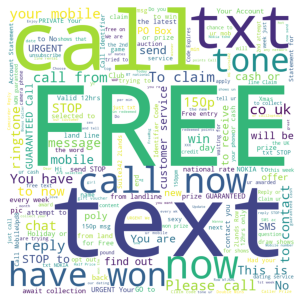

In [14]:
plt.figure(figsize = (4,4), facecolor = None) 
plt.imshow(spamcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

#### Words such as 'free','call','won','text' occur most frequently in spam messages.

In [15]:
hamcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(texts_ham)

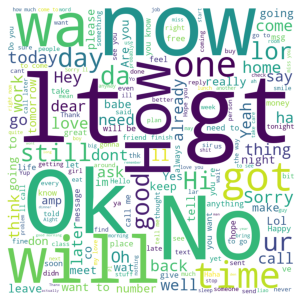

In [16]:
plt.figure(figsize = (4,4), facecolor = None) 
plt.imshow(hamcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [17]:
labels = {'spam':0,'ham':1}
df['Label'] = df['Label'].map(labels)

#### Common words such as 'now','no','ok' occur most frequently in ham messages.

In [47]:
X = df['Text'].values
y = df['Label'].values

In [48]:
## Train Test Split
from sklearn.model_selection import train_test_split

Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,random_state=21)

## Converting the text data into numerical data:
### We will try different vectorizer and compare their results to choose the best one.

In [49]:
## Using Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

count_vectorizer = CountVectorizer()
Xtrain_count = count_vectorizer.fit_transform(Xtrain)
Xtest_count = count_vectorizer.transform(Xtest)

In [50]:
## Using TF-IDF Vectorizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),encoding='latin-1')
Xtrain_tf = tfidf_vectorizer.fit_transform(Xtrain)
Xtest_tf = tfidf_vectorizer.transform(Xtest)

## Model Building:

### Naive Bayes Classifier

In [51]:
from sklearn.naive_bayes import MultinomialNB

model_nb_count = MultinomialNB()
model_nb_tf = MultinomialNB()
model_nb_count.fit(Xtrain_count,ytrain)
model_nb_tf.fit(Xtrain_tf,ytrain)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [52]:
y_pred_count = model_nb_count.predict(Xtest_count)
y_pred_tf = model_nb_tf.predict(Xtest_tf)

In [53]:
from sklearn.metrics import classification_report

print('Naive Bayes with Count Vectorizer')
print(classification_report(y_pred_count,ytest))

print('Naive Bayes with TF-IDF Vectorizer')
print(classification_report(y_pred_tf,ytest))

Naive Bayes with Count Vectorizer
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       219
           1       0.99      0.99      0.99      1453

    accuracy                           0.98      1672
   macro avg       0.96      0.96      0.96      1672
weighted avg       0.98      0.98      0.98      1672

Naive Bayes with TF-IDF Vectorizer
              precision    recall  f1-score   support

           0       0.58      1.00      0.73       130
           1       1.00      0.94      0.97      1542

    accuracy                           0.94      1672
   macro avg       0.79      0.97      0.85      1672
weighted avg       0.97      0.94      0.95      1672



#### Since, it is an imbalanced dataset and we will focus on the weighted average of precision. Naive Bayes performs better with count vectorizer than with tfidf vectorizer 

In [54]:
print('Naive Bayes with Count Vectorizer')
print(round(weighted_avg_precision_score(y_pred_count,ytest),5))

print('Naive Bayes with TF-IDF Vectorizer')
print(round(weighted_avg_precision_score(y_pred_tf,ytest),5))

Naive Bayes with Count Vectorizer
0.98132
Naive Bayes with TF-IDF Vectorizer
0.94721


### RandomForestClassifier

In [55]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(class_weight='balanced',random_state=21)

In [56]:
from sklearn.model_selection import RandomizedSearchCV
# Create parameter grid

param_grid = {
    "n_estimators":[100,200,300],
    "criterion":["gini","entropy"],
    "max_features" : ['auto','sqrt'],
    "max_depth" : [1,2,3,5],
    "min_samples_split" : [2,5,10],
    "min_samples_leaf" : [1,2,5],
}

In [57]:
model_count = RandomizedSearchCV(estimator=model_rf,param_distributions=param_grid,scoring="average_precision",verbose=2,cv=5,n_jobs=-1,random_state=21)
model_tf = RandomizedSearchCV(estimator=model_rf,param_distributions=param_grid,scoring="average_precision",verbose=2,cv=5,n_jobs=-1,random_state=21)

In [58]:
model_count.fit(Xtrain_count,ytrain)
model_tf.fit(Xtrain_tf,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.6s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
         

In [59]:
y_pred_count = model_count.predict(Xtest_count)
y_pred_tf = model_tf.predict(Xtest_tf)

In [60]:
from sklearn.metrics import classification_report,precision_score

print('RandomForest with Count Vectorizer')
print(round(weighted_avg_precision_score(y_pred_count,ytest),5))

print('RandomForest with TF-IDF Vectorizer')
print(round(weighted_avg_precision_score(y_pred_tf,ytest),5))

RandomForest with Count Vectorizer
0.979
RandomForest with TF-IDF Vectorizer
0.97729


## XGBoost

In [61]:
weights = (y == 1).sum() / (1.0 * (y == 0).sum()) # for unbalanced datasets, these weights are recommended
parametersXGB = {'max_depth':3,'scale_pos_weight':weights,'n_jobs':-1,'random_state':21,'learning_rate':0.1}

XGB_count = XGBClassifier(**parametersXGB).fit(Xtrain_count,ytrain)
XGB_tf = XGBClassifier(**parametersXGB).fit(Xtrain_tf,ytrain)

# Prediction
y_pred_count = XGB_count.predict(Xtest_count)
y_pred_tf = XGB_tf.predict(Xtest_tf)

In [62]:
from sklearn.metrics import classification_report,precision_score

print('XGBoost with Count Vectorizer')
print(round(weighted_avg_precision_score(y_pred_count,ytest),5))

print('XGBoost with TF-IDF Vectorizer')
print(round(weighted_avg_precision_score(y_pred_tf,ytest),5))

XGBoost with Count Vectorizer
0.95574
XGBoost with TF-IDF Vectorizer
0.94565


### Naive Bayes with Count Vectorizer inputs gives the best weighted precision score

In [64]:
import joblib
joblib.dump(model_nb_count,'modelNBCount.pkl')

['modelNBCount.pkl']

In [65]:
import joblib
joblib.dump(count_vectorizer,'count_vectorizer.pkl')

['count_vectorizer.pkl']